In [23]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frame 3')

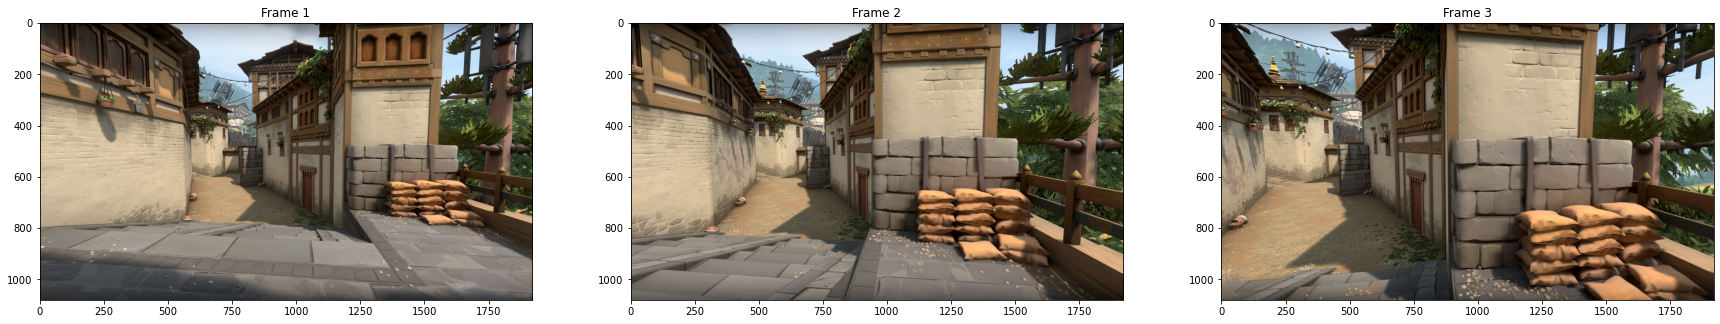

In [24]:
# Read images
img1 = cv2.imread("./files/img1.png")
img2 = cv2.imread("./files/img2.png")
img3 = cv2.imread("./files/img3.png")

fig, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(img1[:,:, ::-1])
axs[0].set_title("Frame 1")
axs[1].imshow(img2[:,:, ::-1])
axs[1].set_title("Frame 2")
axs[2].imshow(img3[:,:, ::-1])
axs[2].set_title("Frame 3")

In [25]:
vr2d = np.load("files/vr2d.npy")[:,0,:][None]
vr3d = np.load("files/vr3d.npy")[:,0,:][None]
print(f"vr2d has shape: {vr2d.shape}, vr3d has shape: {vr3d.shape}")

vr2d has shape: (1, 20, 2), vr3d has shape: (1, 20, 3)


In [26]:
fx, fy = 100, 100
cx, cy = 960, 540
cameraMatrix = np.array([[fx, 0, cx,], [0, fy, cy], [0, 0, 1]], dtype=np.float32)
distCoeffs = np.array([0,0,0,0,0], dtype=np.float32)
print("Input camera matrix: \n", cameraMatrix)

Input camera matrix: 
 [[100.   0. 960.]
 [  0. 100. 540.]
 [  0.   0.   1.]]


In [27]:
# Applying assumptions for camera: aspect ratio is fixed, principal point is fixed (cx=960, cy=540) and there is no distortion.
flags = cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_FIX_PRINCIPAL_POINT
ret, cam_matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(vr3d, vr2d, (1920,1080), cameraMatrix=cameraMatrix, distCoeffs=distCoeffs, flags=flags)
print("Resulting intrinsic camera matrix: \n", cam_matrix)

Resulting intrinsic camera matrix: 
 [[337.08679123   0.         960.        ]
 [  0.         388.34497065 540.        ]
 [  0.           0.           1.        ]]


In [28]:
r_vecs

[array([[ 1.11146806],
        [-1.25918529],
        [ 1.34447844]])]

In [29]:
t_vecs

[array([[-3.90537185],
        [ 1.86872252],
        [-0.33133196]])]

In [30]:
def compute_matches(i0, i1, cam_matrix, plot=True):
    
    """
    This fn gets two images and the intrinsic camera matrix as the input, 
    returns relative transformation between two views.
    Plots the matches if the plot flag is set to True.
    """
    
    # ORB Detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(i0, None)
    kp2, des2 = orb.detectAndCompute(i1, None)

    # Brute Force Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1, pts2 = [], []

    for i in range(len(matches)):

        src_index = matches[i].trainIdx
        dst_index = matches[i].queryIdx
        pts1.append(kp1[src_index].pt)
        pts2.append(kp2[dst_index].pt)

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    if plot:
        matching_result = cv2.drawMatches(img1[:,:,::-1], kp1, img2[:,:,::-1], kp2, matches, None, flags=2)
        plt.figure(figsize=(15,15))
        plt.imshow(matching_result)
        plt.title("Matched Keypoints")
    
    
    # Calculates an essential matrix from the corresponding points in two images.
    # Note that this function assumes that points1 and points2 are feature points from cameras with the same camera matrix.
    e_0, mask = cv2.findEssentialMat(pts1, pts2, cam_matrix)
    
    # Recover relative camera rotation and translation from an estimated essential matrix and the corresponding points in two images, using cheirality check.
    ret = cv2.recoverPose(e_0, pts1, pts2)
    
    rot_matrix = ret[1] # Recovered relative rotation.
    translation_vec = ret[2] # Recovered relative translation.
    
    print(f"Rot matrix: \n {rot_matrix}, \n translation_vec: \n {translation_vec}")
    
    return rot_matrix, translation_vec


Rot matrix: 
 [[ 0.88744517  0.15667046  0.43346907]
 [-0.39801763  0.73474278  0.54930412]
 [-0.23242854 -0.66000562  0.71440154]], 
 translation_vec: 
 [[ 0.77953483]
 [-0.4441403 ]
 [ 0.44166145]]


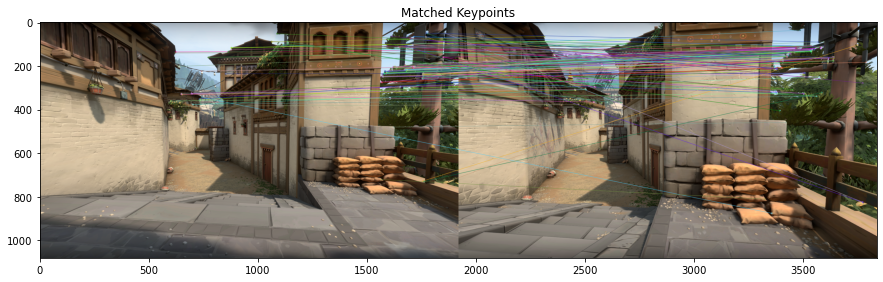

In [31]:
r12, t12 = compute_matches(img1, img2, cam_matrix)

Rot matrix: 
 [[-0.30268144  0.6499581  -0.69709283]
 [ 0.6906568  -0.35444555 -0.63036619]
 [-0.65679306 -0.67225205 -0.34161389]], 
 translation_vec: 
 [[ 0.84156425]
 [-0.42138638]
 [ 0.33793955]]


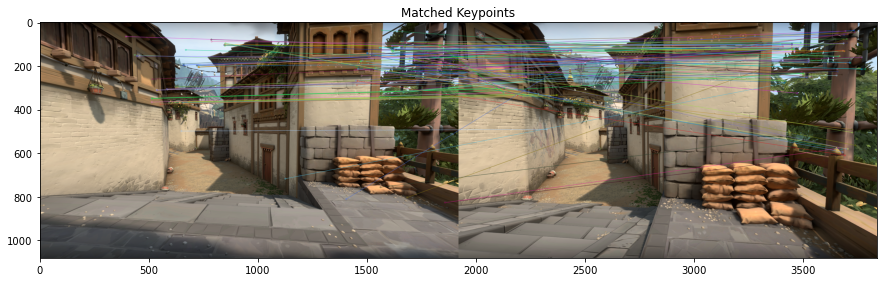

In [32]:
r23, t23 = compute_matches(img2, img3, cam_matrix)

In [33]:
RT_12 = np.concatenate([r12, t12], axis=1)
RT_12_4x4  = np.concatenate([RT_12, np.array([[0, 0, 0, 1]])])
print(RT_12_4x4)

[[ 0.88744517  0.15667046  0.43346907  0.77953483]
 [-0.39801763  0.73474278  0.54930412 -0.4441403 ]
 [-0.23242854 -0.66000562  0.71440154  0.44166145]
 [ 0.          0.          0.          1.        ]]


In [34]:
RT_23 = np.concatenate([r23, t23], axis=1)
RT_23_4x4 = np.concatenate([RT_23, np.array([[0, 0, 0, 1]])])
print(RT_23_4x4)

[[-0.30268144  0.6499581  -0.69709283  0.84156425]
 [ 0.6906568  -0.35444555 -0.63036619 -0.42138638]
 [-0.65679306 -0.67225205 -0.34161389  0.33793955]
 [ 0.          0.          0.          1.        ]]


We can chain two transformations together by multiplying matrices one after the other. The result will be a single matrix that encodes the full transformation. 
The order that we use to apply transformations is very important; matrix multiplication is not commutative. 

In [35]:
RT_13_4x4 = np.matmul(RT_23_4x4, RT_12_4x4)
print(RT_13_4x4)

[[-0.3652837   0.89021597 -0.27218257  0.00906191]
 [ 0.90051072  0.26382443 -0.34565462 -0.00398023]
 [-0.23589885 -0.37136532 -0.89801978 -0.02635698]
 [ 0.          0.          0.          1.        ]]


# Camera Trajectory

In [36]:
cam_xyzw_1 = np.array([0., 0. , 0. ,1.])

In [37]:
cam_xyzw_2 = RT_12_4x4.dot(cam_xyzw_1)
print(cam_xyzw_2)

[ 0.77953483 -0.4441403   0.44166145  1.        ]


In [38]:
cam_xyzw_3 = RT_13_4x4.dot(cam_xyzw_1)
print(cam_xyzw_3)

[ 0.00906191 -0.00398023 -0.02635698  1.        ]


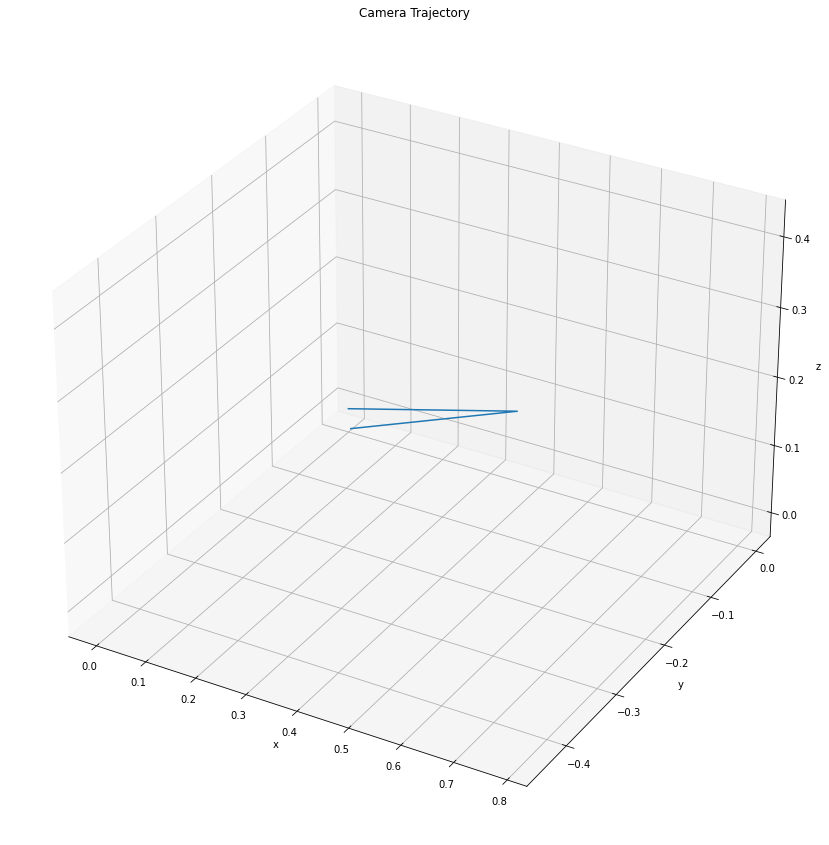

In [39]:
xs = np.array([cam_xyzw_1[0], cam_xyzw_2[0], cam_xyzw_3[0]])
ys = np.array([cam_xyzw_1[1], cam_xyzw_2[1], cam_xyzw_3[1]])
zs = np.array([cam_xyzw_1[2], cam_xyzw_2[2], cam_xyzw_3[2]])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Camera Trajectory')
plt.show()

# Camera Pose

In [40]:
input_cm = np.eye(4)

In [41]:
cm1 = np.matmul(RT_12_4x4, input_cm)
print(cm1)

[[ 0.88744517  0.15667046  0.43346907  0.77953483]
 [-0.39801763  0.73474278  0.54930412 -0.4441403 ]
 [-0.23242854 -0.66000562  0.71440154  0.44166145]
 [ 0.          0.          0.          1.        ]]


In [42]:
cm2 = np.matmul(RT_13_4x4, input_cm)
print(cm2)

[[-0.3652837   0.89021597 -0.27218257  0.00906191]
 [ 0.90051072  0.26382443 -0.34565462 -0.00398023]
 [-0.23589885 -0.37136532 -0.89801978 -0.02635698]
 [ 0.          0.          0.          1.        ]]
